### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [153]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sqlalchemy import create_engine

In [128]:
## Import Rent Data
# Original data source: https://www.kaggle.com/datasets/austinreese/usa-housing-listings
# Last updated Jan 2020
# Filtered down for 12 largest metros according to: https://worldpopulationreview.com/us-cities

# Read file and display
rent = "Resources/housing_majors.csv"
rent = pd.read_csv(rent)

# Standardize city names
cities_list = rent.drop_duplicates(subset=['region'])
rent = rent.replace([city for city in cities_list['region']], 
                    ['SF/SJ', 'SD', 'JAX', 'CHI', 'NY', 'PHL', 'ATX', 'DFW', 'HOU', 'SA', 'PHX', 'LA'])

# Display data 
rent

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7048692414,https://sfbay.craigslist.org/scz/apa/d/capitol...,SF/SJ,https://sfbay.craigslist.org,1650,apartment,325,1,1.0,0,...,0,0,0,no laundry on site,off-street parking,https://images.craigslist.org/00Y0Y_1S9nzXZ8NF...,Lovely Studio With Small patio for your seren...,36.9771,-121.953,ca
1,7049506190,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1450,apartment,700,1,1.0,0,...,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00G0G_cG4yFLfaAa...,Apartment Details: -1 bedroom 1 bath - Proper...,32.7423,-117.095,ca
2,7043935679,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1700,apartment,700,1,1.0,0,...,0,0,0,laundry on site,NaN,https://images.craigslist.org/00g0g_fjiyS1iI2o...,1 Bedroom with a Great View!!! Minutes to free...,32.7277,-117.165,ca
3,7035359947,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2685,townhouse,1127,2,2.0,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00g0g_dA6FtxqdV9...,The life youâve always imagined is at Levant...,32.7958,-117.071,ca
4,7049978012,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1390,apartment,263,0,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00v0v_akWNyI1F4d...,THE BARCELONA The perfect pairing of location...,32.7294,-117.162,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26088,7035391481,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2525,apartment,1127,2,2.0,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00E0E_bs0T3dPEIH...,"Located near Mission Valley, the townhomes at ...",32.7958,-117.071,ca
26089,7049783450,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2593,apartment,1094,2,2.0,1,...,0,0,0,w/d in unit,NaN,https://images.craigslist.org/01414_kiWespdEZL...,To schedule a tour We now book our tour appoin...,32.8274,-117.138,ca
26090,7049426671,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1300,apartment,490,1,1.0,1,...,1,0,1,laundry on site,off-street parking,https://images.craigslist.org/00B0B_bKWtLiBFGY...,Beautiful Turn-Key 1 Bed/1 Bath is located in ...,32.7560,-117.121,ca
26091,7049461332,https://sandiego.craigslist.org/nsd/apa/d/esco...,SD,https://sandiego.craigslist.org,1646,apartment,812,2,1.0,1,...,0,0,0,NaN,NaN,https://images.craigslist.org/00i0i_lgzbYDbzfP...,Bedrooms: 2 Bathrooms: 1 Square Feet: 812 Int...,33.1435,-117.097,ca


In [129]:
## Filter out unreasonable values and missing lat/long, add price_per_sqfeet
rent = rent.loc[(rent["price"] >= 100) & (rent["price"] <= 20000) & 
                (rent["sqfeet"] >= 200) & (rent["sqfeet"] <= 10000) &
                (rent["beds"] <= 7) & 
                (rent["baths"] <= 7), :]
rent = rent[rent.lat.notnull()]
rent = rent[rent.long.notnull()]
rent['price_per_sqfeet'] = rent['price'] / rent['sqfeet']
rent['laundry_in_unit'] = np.where(rent['laundry_options'] == 'w/d in unit', 1, 0)
rent['garage_parking'] = np.where((rent['parking_options'] == 'attached garage') | (rent['parking_options'] == 'carport') |
                                  (rent['parking_options'] == 'detached garage') | (rent['parking_options'] == 'valet parking'), 1, 0)
rent

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,laundry_options,parking_options,image_url,description,lat,long,state,price_per_sqfeet,laundry_in_unit,garage_parking
0,7048692414,https://sfbay.craigslist.org/scz/apa/d/capitol...,SF/SJ,https://sfbay.craigslist.org,1650,apartment,325,1,1.0,0,...,no laundry on site,off-street parking,https://images.craigslist.org/00Y0Y_1S9nzXZ8NF...,Lovely Studio With Small patio for your seren...,36.9771,-121.953,ca,5.076923,0,0
1,7049506190,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1450,apartment,700,1,1.0,0,...,laundry on site,off-street parking,https://images.craigslist.org/00G0G_cG4yFLfaAa...,Apartment Details: -1 bedroom 1 bath - Proper...,32.7423,-117.095,ca,2.071429,0,0
2,7043935679,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1700,apartment,700,1,1.0,0,...,laundry on site,NaN,https://images.craigslist.org/00g0g_fjiyS1iI2o...,1 Bedroom with a Great View!!! Minutes to free...,32.7277,-117.165,ca,2.428571,0,0
3,7035359947,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2685,townhouse,1127,2,2.0,1,...,w/d in unit,attached garage,https://images.craigslist.org/00g0g_dA6FtxqdV9...,The life youâve always imagined is at Levant...,32.7958,-117.071,ca,2.382431,1,1
4,7049978012,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1390,apartment,263,0,1.0,1,...,laundry on site,street parking,https://images.craigslist.org/00v0v_akWNyI1F4d...,THE BARCELONA The perfect pairing of location...,32.7294,-117.162,ca,5.285171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26088,7035391481,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2525,apartment,1127,2,2.0,1,...,w/d in unit,attached garage,https://images.craigslist.org/00E0E_bs0T3dPEIH...,"Located near Mission Valley, the townhomes at ...",32.7958,-117.071,ca,2.240461,1,1
26089,7049783450,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2593,apartment,1094,2,2.0,1,...,w/d in unit,NaN,https://images.craigslist.org/01414_kiWespdEZL...,To schedule a tour We now book our tour appoin...,32.8274,-117.138,ca,2.370201,1,0
26090,7049426671,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1300,apartment,490,1,1.0,1,...,laundry on site,off-street parking,https://images.craigslist.org/00B0B_bKWtLiBFGY...,Beautiful Turn-Key 1 Bed/1 Bath is located in ...,32.7560,-117.121,ca,2.653061,0,0
26091,7049461332,https://sandiego.craigslist.org/nsd/apa/d/esco...,SD,https://sandiego.craigslist.org,1646,apartment,812,2,1.0,1,...,NaN,NaN,https://images.craigslist.org/00i0i_lgzbYDbzfP...,Bedrooms: 2 Bathrooms: 1 Square Feet: 812 Int...,33.1435,-117.097,ca,2.027094,0,0


In [154]:
## Add database to sql
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
engine = create_engine('sqlite://', echo = False)
rent.to_sql('rent_data', con = engine)

In [155]:
## Query data from sql
engine.execute("SELECT * FROM rent_data").fetchall()

[(0, 7048692414, 'https://sfbay.craigslist.org/scz/apa/d/capitola-quaint-studio-walking-distance/7048692414.html', 'SF/SJ', 'https://sfbay.craigslist.org', 1650, 'apartment', 325, 1, 1.0, 0, 0, 0, 0, 0, 0, 'no laundry on site', 'off-street parking', 'https://images.craigslist.org/00Y0Y_1S9nzXZ8NF6_600x450.jpg', 'Lovely Studio  With Small patio for your serene garden setting,  Kitchen, bathroom, living area, storage. Approximately 325 sq ft.   1 1/2 blocks to  ... (67 characters truncated) ... 00 includes all utilities except internet cable and telephone.  Security deposit-$1500.00  No pets please  No smoking  *Please Do Not Disturb Tenant*', 36.9771, -121.953, 'ca', 5.076923076923077, 0, 0),
 (1, 7049506190, 'https://sandiego.craigslist.org/csd/apa/d/san-diego-new-floor-custom-paint-wall/7049506190.html', 'SD', 'https://sandiego.craigslist.org', 1450, 'apartment', 700, 1, 1.0, 0, 0, 0, 0, 0, 0, 'laundry on site', 'off-street parking', 'https://images.craigslist.org/00G0G_cG4yFLfaAaM_60

In [156]:
## Sql data back to pd df
rent = pd.read_sql("SELECT * FROM rent_data", engine.connect())
rent

,index,id,url,region,region_url,price,type,sqfeet,beds,baths,...,laundry_options,parking_options,image_url,description,lat,long,state,price_per_sqfeet,laundry_in_unit,garage_parking
0,0,7048692414,https://sfbay.craigslist.org/scz/apa/d/capitol...,SF/SJ,https://sfbay.craigslist.org,1650,apartment,325,1,1.0,...,no laundry on site,off-street parking,https://images.craigslist.org/00Y0Y_1S9nzXZ8NF...,Lovely Studio With Small patio for your seren...,36.9771,-121.953,ca,5.076923,0,0
1,1,7049506190,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1450,apartment,700,1,1.0,...,laundry on site,off-street parking,https://images.craigslist.org/00G0G_cG4yFLfaAa...,Apartment Details: -1 bedroom 1 bath - Proper...,32.7423,-117.095,ca,2.071429,0,0
2,2,7043935679,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1700,apartment,700,1,1.0,...,laundry on site,None,https://images.craigslist.org/00g0g_fjiyS1iI2o...,1 Bedroom with a Great View!!! Minutes to free...,32.7277,-117.165,ca,2.428571,0,0
3,3,7035359947,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2685,townhouse,1127,2,2.0,...,w/d in unit,attached garage,https://images.craigslist.org/00g0g_dA6FtxqdV9...,The life youâve always imagined is at Levant...,32.7958,-117.071,ca,2.382431,1,1
4,4,7049978012,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1390,apartment,263,0,1.0,...,laundry on site,street parking,https://images.craigslist.org/00v0v_akWNyI1F4d...,THE BARCELONA The perfect pairing of location...,32.7294,-117.162,ca,5.285171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25590,26088,7035391481,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2525,apartment,1127,2,2.0,...,w/d in unit,attached garage,https://images.craigslist.org/00E0E_bs0T3dPEIH...,"Located near Mission Valley, the townhomes at ...",32.7958,-117.071,ca,2.240461,1,1
25591,26089,7049783450,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2593,apartment,1094,2,2.0,...,w/d in unit,None,https://images.craigslist.org/01414_kiWespdEZL...,To schedule a tour We now book our tour appoin...,32.8274,-117.138,ca,2.370201,1,0
25592,26090,7049426671,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1300,apartment,490,1,1.0,...,laundry on site,off-street parking,https://images.craigslist.org/00B0B_bKWtLiBFGY...,Beautiful Turn-Key 1 Bed/1 Bath is located in ...,32.7560,-117.121,ca,2.653061,0,0
25593,26091,7049461332,https://sandiego.craigslist.org/nsd/apa/d/esco...,SD,https://sandiego.craigslist.org,1646,apartment,812,2,1.0,...,None,None,https://images.craigslist.org/00i0i_lgzbYDbzfP...,Bedrooms: 2 Bathrooms: 1 Square Feet: 812 Int...,33.1435,-117.097,ca,2.027094,0,0


In [157]:
# Group by city and create table of summary stats for 'price'
rent_summary = rent.groupby(["region"])
rent_summary['price'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
SF/SJ,2307.0,3074.712614,1460.015907,1000.0,2250.0,2750.0,3500.0,20000.0
NY,723.0,2643.741355,1108.468553,790.0,1900.0,2400.0,3099.0,13125.0
LA,2232.0,2509.583333,1130.463921,510.0,1800.0,2295.0,2910.0,18500.0
SD,2346.0,2254.057545,847.498350,100.0,1746.0,2056.0,2550.0,11995.0
CHI,1483.0,1723.163857,847.958760,450.0,1196.0,1500.0,2000.0,10000.0
PHL,1833.0,1620.361702,679.338637,149.0,1171.0,1495.0,1925.0,5795.0
ATX,2418.0,1379.616212,532.091338,455.0,1053.0,1275.0,1570.0,12975.0
DFW,2265.0,1294.348786,479.278222,116.0,976.0,1218.0,1520.0,6800.0
PHX,2036.0,1208.961198,397.668446,209.0,975.0,1180.0,1370.0,5500.0


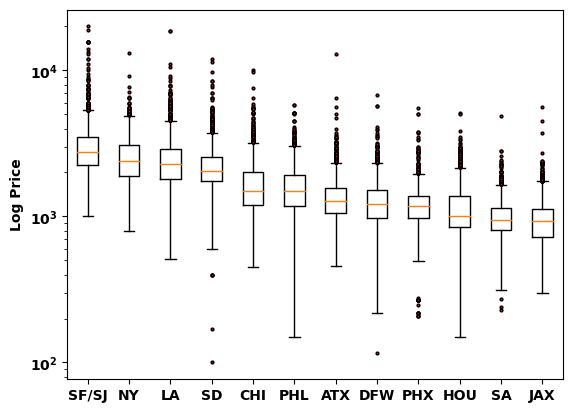

In [158]:
# Boxplot - Log Price
cities = rent_summary['price'].describe().sort_values(by = 'mean', ascending = False).iloc[:, 0]
city_list = [city for city in cities.index]

city0 = rent.loc[rent['region'] == city_list[0]]['price']
city1 = rent.loc[rent['region'] == city_list[1]]['price']
city2 = rent.loc[rent['region'] == city_list[2]]['price']
city3 = rent.loc[rent['region'] == city_list[3]]['price']
city4 = rent.loc[rent['region'] == city_list[4]]['price']
city5 = rent.loc[rent['region'] == city_list[5]]['price']
city6 = rent.loc[rent['region'] == city_list[6]]['price']
city7 = rent.loc[rent['region'] == city_list[7]]['price']
city8 = rent.loc[rent['region'] == city_list[8]]['price']
city9 = rent.loc[rent['region'] == city_list[9]]['price']
city10 = rent.loc[rent['region'] == city_list[10]]['price']
city11 = rent.loc[rent['region'] == city_list[11]]['price']

prices = [city0, city1, city2, city3, city4, city5, city6, city7, city8, city9, city10, city11]

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Log Price')
ax1.boxplot(prices, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'red'})
ax1.set_xticklabels(city_list)
plt.yscale("log")
plt.show()

In [159]:
# Group by city and create table of summary stats for 'sqfeet'
rent_summary['sqfeet'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CHI,1483.0,1033.334457,481.480698,250.0,710.0,924.0,1200.00,5335.0
HOU,1700.0,1018.604706,508.595897,200.0,700.0,900.0,1140.75,4050.0
PHL,1833.0,964.278232,385.265936,300.0,700.0,900.0,1120.00,3072.0
SF/SJ,2307.0,962.788903,507.728955,200.0,700.0,852.0,1096.00,6500.0
SD,2346.0,958.153026,395.661112,200.0,700.0,900.0,1120.75,5000.0
PHX,2036.0,957.498527,427.230769,240.0,720.0,900.0,1100.00,7290.0
JAX,4211.0,955.769651,307.201847,288.0,753.0,920.0,1105.00,4005.0
DFW,2265.0,953.381457,336.139928,247.0,716.0,907.0,1106.00,4455.0
SA,2041.0,951.847134,398.443805,260.0,675.0,915.0,1100.00,3858.0


In [160]:
# Group by city and create table of summary stats for 'price_per_sqfeet'
rent_summary['price_per_sqfeet'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
SF/SJ,2307.0,3.435870,1.156612,0.466667,2.680557,3.203125,4.034053,8.844444
NY,723.0,3.164485,1.300439,0.791667,2.200000,2.777778,4.182833,7.661996
LA,2232.0,2.897057,0.989113,0.229980,2.255245,2.750000,3.368749,8.780645
SD,2346.0,2.489453,0.710412,0.200000,2.064078,2.360705,2.810680,7.040816
PHL,1833.0,1.842089,0.803709,0.155208,1.326087,1.652334,2.326531,6.074074
CHI,1483.0,1.789769,0.718594,0.357143,1.292686,1.583333,2.194138,5.386100
ATX,2418.0,1.572963,0.527713,0.250370,1.282346,1.477772,1.791020,13.921674
DFW,2265.0,1.393891,0.366915,0.150649,1.182022,1.357590,1.584146,3.238866
PHX,2036.0,1.351386,0.378556,0.138546,1.157407,1.323848,1.501203,4.230769


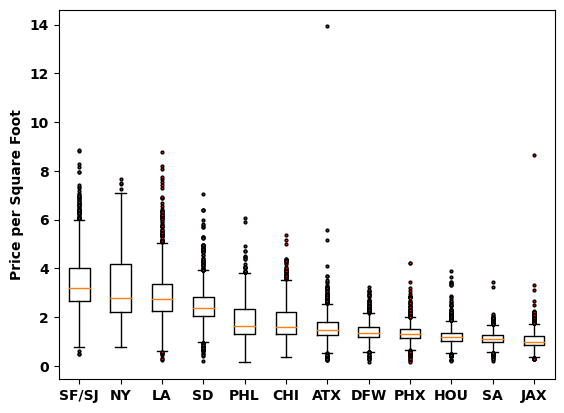

In [161]:
# Boxplot - Price per sqft
cities = rent_summary['price_per_sqfeet'].describe().sort_values(by = 'mean', ascending = False).iloc[:, 0]
city_list = [city for city in cities.index]

city0 = rent.loc[rent['region'] == city_list[0]]['price_per_sqfeet']
city1 = rent.loc[rent['region'] == city_list[1]]['price_per_sqfeet']
city2 = rent.loc[rent['region'] == city_list[2]]['price_per_sqfeet']
city3 = rent.loc[rent['region'] == city_list[3]]['price_per_sqfeet']
city4 = rent.loc[rent['region'] == city_list[4]]['price_per_sqfeet']
city5 = rent.loc[rent['region'] == city_list[5]]['price_per_sqfeet']
city6 = rent.loc[rent['region'] == city_list[6]]['price_per_sqfeet']
city7 = rent.loc[rent['region'] == city_list[7]]['price_per_sqfeet']
city8 = rent.loc[rent['region'] == city_list[8]]['price_per_sqfeet']
city9 = rent.loc[rent['region'] == city_list[9]]['price_per_sqfeet']
city10 = rent.loc[rent['region'] == city_list[10]]['price_per_sqfeet']
city11 = rent.loc[rent['region'] == city_list[11]]['price_per_sqfeet']

prices = [city0, city1, city2, city3, city4, city5, city6, city7, city8, city9, city10, city11]

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Price per Square Foot')
ax1.boxplot(prices, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'red'})
ax1.set_xticklabels(city_list)
#plt.yscale("log")
plt.show()

In [162]:
# Group by city and create table of summary stats for 'beds'
rent_summary['beds'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
JAX,4211.0,1.853716,0.731362,0.0,1.0,2.0,2.0,6.0
PHX,2036.0,1.774558,0.927209,0.0,1.0,2.0,2.0,6.0
SA,2041.0,1.761391,0.912011,0.0,1.0,2.0,2.0,5.0
CHI,1483.0,1.749831,0.939531,0.0,1.0,2.0,2.0,5.0
SD,2346.0,1.738278,0.883708,0.0,1.0,2.0,2.0,5.0
PHL,1833.0,1.695035,0.934692,0.0,1.0,2.0,2.0,6.0
NY,723.0,1.686030,1.045852,0.0,1.0,2.0,2.0,5.0
HOU,1700.0,1.684706,0.838663,0.0,1.0,2.0,2.0,5.0
SF/SJ,2307.0,1.666233,0.937093,0.0,1.0,2.0,2.0,7.0


In [163]:
# Group by city and create table of summary stats for 'baths'
rent_summary['baths'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
SD,2346.0,1.524084,0.596861,0.0,1.0,1.0,2.0,4.5
PHX,2036.0,1.518418,0.565841,0.0,1.0,1.5,2.0,4.0
SA,2041.0,1.504900,0.648509,0.0,1.0,1.0,2.0,5.0
HOU,1700.0,1.500294,0.612192,0.0,1.0,1.0,2.0,4.0
ATX,2418.0,1.473325,0.610395,0.0,1.0,1.0,2.0,4.0
JAX,4211.0,1.429589,0.525337,0.0,1.0,1.0,2.0,4.0
SF/SJ,2307.0,1.429345,0.622811,0.0,1.0,1.0,2.0,5.5
LA,2232.0,1.426075,0.600613,0.0,1.0,1.0,2.0,6.5
DFW,2265.0,1.415894,0.588549,0.0,1.0,1.0,2.0,4.0


In [164]:
# Group by city and create table of % 'dogs_allowed'
rent_summary['dogs_allowed'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
ATX,2418.0,0.777916
DFW,2265.0,0.750993
PHX,2036.0,0.724951
JAX,4211.0,0.706958
HOU,1700.0,0.646471
SA,2041.0,0.643312
SD,2346.0,0.635550
LA,2232.0,0.622760
CHI,1483.0,0.621713


In [165]:
# Group by city and create table of % 'smoking_allowed'
rent_summary['smoking_allowed'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
ATX,2418.0,0.889992
PHX,2036.0,0.887033
SA,2041.0,0.880941
HOU,1700.0,0.870000
PHL,1833.0,0.849973
JAX,4211.0,0.844930
DFW,2265.0,0.844592
NY,723.0,0.799447
LA,2232.0,0.689964


In [166]:
# Group by city and create table of % 'electric_vehicle_charge'
rent_summary['electric_vehicle_charge'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
SF/SJ,2307.0,0.100997
LA,2232.0,0.094982
SD,2346.0,0.071185
HOU,1700.0,0.018235
PHL,1833.0,0.014730
NY,723.0,0.011065
CHI,1483.0,0.010789
ATX,2418.0,0.009098
PHX,2036.0,0.003929


In [167]:
# Group by city and create table of % 'laundry_in_unit'
rent_summary['laundry_in_unit'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
SF/SJ,2307.0,0.534460
PHL,1833.0,0.484997
PHX,2036.0,0.480845
SD,2346.0,0.474851
CHI,1483.0,0.435604
LA,2232.0,0.357079
HOU,1700.0,0.324706
ATX,2418.0,0.301075
JAX,4211.0,0.228212


In [168]:
# Group by city and create table of % 'garage_parking'
rent_summary['garage_parking'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
SF/SJ,2307.0,0.655830
LA,2232.0,0.513441
PHX,2036.0,0.508841
SD,2346.0,0.484655
CHI,1483.0,0.350641
HOU,1700.0,0.325294
DFW,2265.0,0.282561
ATX,2418.0,0.203060
NY,723.0,0.188105


In [169]:
## Final summary dataframe for rent by city
listings = rent_summary['price'].count()
price_mean = rent_summary['price'].mean()
price_median = rent_summary['price'].median()
sqfeet_mean = rent_summary['sqfeet'].mean()
sqfeet_median = rent_summary['sqfeet'].median()
price_per_sqfeet = rent_summary['price_per_sqfeet'].mean()
beds_mean = rent_summary['beds'].mean()
baths_mean = rent_summary['baths'].mean()

rent_grouped = pd.DataFrame({"listings": listings,
                             "price_mean": price_mean,
                             "price_median": price_median,
                             "sq_feet_mean": sqfeet_mean,
                             "sq_feet_median": sqfeet_median,
                             "price_per_sqfeet": price_per_sqfeet,
                             "beds_mean": beds_mean,
                             "baths_mean": baths_mean})
rent_grouped

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean
region,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418


In [170]:
## Import income data
# Source: https://www.bea.gov/data/income-saving/personal-income-county-metro-and-other-areas ('Metropolitian Area Table')
income = "Resources/income_data.xlsx"
income = pd.read_excel(income)

# Select relevant rows and columns
income = income.iloc[7:391, [0,2]]

# Rename columns
income.rename(columns = {'Table 2. Per Capita Personal Income, by Metropolitan Area, 2019–2021': "region", 
                         'Unnamed: 2': "Per_Capita_Income_2020"}, inplace = True)

# Filter for major cities
city_list = ['San Francisco-Oakland-Berkeley, CA', 'San Jose-Sunnyvale-Santa Clara, CA', 'San Diego-Chula Vista-Carlsbad, CA', 
             'Jacksonville, FL', 'Chicago-Naperville-Elgin, IL-IN-WI', 'New York-Newark-Jersey City, NY-NJ-PA', 
             'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', 'Austin-Round Rock-Georgetown, TX', 'Dallas-Fort Worth-Arlington, TX', 
             'Houston-The Woodlands-Sugar Land, TX', 'San Antonio-New Braunfels, TX', 'Phoenix-Mesa-Chandler, AZ', 
             'Los Angeles-Long Beach-Anaheim, CA']
income_filter = income.loc[income['region'].isin(city_list)]

# Standardize city names
income = income_filter.replace([city for city in income_filter['region']], 
                               ['ATX', 'CHI', 'DFW', 'HOU', 'JAX', 'LA', 'NY', 'PHL', 'PHX', 'SA', 'SD', 'SF/SJ', 'SF/SJ'])

# Group by cities in order to combine 'San Francisco & San Jose'
income = income.groupby(['region']).mean()

# Display Data
income

,Per_Capita_Income_2020
region,
ATX,64916.0
CHI,66474.0
DFW,61824.0
HOU,61133.0
JAX,55158.0
LA,70280.0
NY,78727.0
PHL,68200.0
PHX,54907.0


In [171]:
## Merge Rent and Income data
data = pd.merge(rent_grouped, income, how="left", on = "region")
data

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean,Per_Capita_Income_2020
region,,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325,64916.0
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691,66474.0
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894,61824.0
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294,61133.0
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589,55158.0
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075,70280.0
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105,78727.0
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250,68200.0
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418,54907.0


In [172]:
## Census File to Load
# Original data source: https://worldpopulationreview.com/us-cities
# Updated for 2020 Census, includes 2023 population

# Read file and display
census = "Resources/census_data.csv"
census = pd.read_csv(census)
census.rename(columns = {'name': "region"}, inplace = True)

# Filter for major cities
city_list = ['San Francisco', 'San Jose', 'San Diego', 'Jacksonville', 'Chicago', 'New York City', 'Philadelphia', 'Austin', 
             'Dallas', 'Fort Worth', 'Houston', 'San Antonio', 'Phoenix', 'Los Angeles']
census_filter = census.loc[census['region'].isin(city_list)]

# Standardize city names
census = census_filter.replace([city for city in census_filter['region']], 
                               ['NY', 'LA', 'CHI', 'HOU', 'PHX', 'PHL', 'SA', 'SD', 'DFW', 'SF/SJ', 'ATX', 'JAX', 'DFW', 'SF/SJ'])

# Group by cities in order to combine 'Dallas & Forth Worth' and 'San Francisco & San Jose'
census = census.groupby(['region']).sum()

# Remove unused columns
census = census.drop(columns = ['pop2023', 'pop2022', 'growth', 'geoid', 'ansicode', 'funcstat', 'metroId', 'rank', 'density'])

# Display data
census

,pop2020,pop2010,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong
region,,,,,,,,
ATX,961855,790390,828638000,17024700,319.939,6.573,30.3012,-97.7527
CHI,2746388,2695598,588882000,17621500,227.369,6.804,41.8376,-87.6818
DFW,2223294,1939022,1774970000,137481300,685.320,53.082,65.5748,-194.1132
HOU,2304580,2099451,1658090000,81248100,640.194,31.370,29.7857,-95.3888
JAX,949611,821784,1935930000,329458000,747.467,127.204,30.3369,-81.6616
LA,3898747,3792621,1214590000,87468500,468.956,33.772,34.0194,-118.4110
NY,8804190,8175133,777983000,434642000,300.381,167.816,40.6635,-73.9387
PHL,1603797,1526006,347782000,21806100,134.279,8.419,40.0094,-75.1333
PHX,1608139,1445632,1340770000,3236740,517.673,1.250,33.5722,-112.0900


In [173]:
## Merge Datasets on city
data = pd.merge(data, census, how = "left", on = "region")
data

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean,Per_Capita_Income_2020,pop2020,pop2010,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong
region,,,,,,,,,,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325,64916.0,961855,790390,828638000,17024700,319.939,6.573,30.3012,-97.7527
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691,66474.0,2746388,2695598,588882000,17621500,227.369,6.804,41.8376,-87.6818
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894,61824.0,2223294,1939022,1774970000,137481300,685.320,53.082,65.5748,-194.1132
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294,61133.0,2304580,2099451,1658090000,81248100,640.194,31.370,29.7857,-95.3888
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589,55158.0,949611,821784,1935930000,329458000,747.467,127.204,30.3369,-81.6616
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075,70280.0,3898747,3792621,1214590000,87468500,468.956,33.772,34.0194,-118.4110
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105,78727.0,8804190,8175133,777983000,434642000,300.381,167.816,40.6635,-73.9387
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250,68200.0,1603797,1526006,347782000,21806100,134.279,8.419,40.0094,-75.1333
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418,54907.0,1608139,1445632,1340770000,3236740,517.673,1.250,33.5722,-112.0900


In [174]:
## Add calculated columns
data['Density'] = data['pop2020'] / data['aland_sqmi']
data['Growth'] = (data['pop2020'] / data['pop2010']) - 1
data['Listings_per_1k_Capita'] = data['listings'] / (data['pop2020'] / 1000)
data['Listings_per_Density'] = data['listings'] / data['aland_sqmi']
data['Rent_per_Income'] = (data['price_mean'] * 12) / data['Per_Capita_Income_2020']
data['Percent_Water'] = data['awater_sqmi'] / data['aland_sqmi']

# Display data
data

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean,Per_Capita_Income_2020,pop2020,...,aland_sqmi,awater_sqmi,intptlat,intptlong,Density,Growth,Listings_per_1k_Capita,Listings_per_Density,Rent_per_Income,Percent_Water
region,,,,,,,,,,,,,,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325,64916.0,961855,...,319.939,6.573,30.3012,-97.7527,3006.369964,0.216937,2.513892,7.557691,0.255028,0.020545
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691,66474.0,2746388,...,227.369,6.804,41.8376,-87.6818,12078.990540,0.018842,0.539982,6.522437,0.311068,0.029925
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894,61824.0,2223294,...,685.320,53.082,65.5748,-194.1132,3244.169147,0.146606,1.018759,3.305025,0.251232,0.077456
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294,61133.0,2304580,...,640.194,31.370,29.7857,-95.3888,3599.815056,0.097706,0.737662,2.655445,0.231474,0.049001
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589,55158.0,949611,...,747.467,127.204,30.3369,-81.6616,1270.438695,0.155548,4.434447,5.633694,0.212650,0.170180
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075,70280.0,3898747,...,468.956,33.772,34.0194,-118.4110,8313.673351,0.027982,0.572492,4.759508,0.428500,0.072015
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105,78727.0,8804190,...,300.381,167.816,40.6635,-73.9387,29310.076203,0.076948,0.082120,2.406943,0.402974,0.558677
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250,68200.0,1603797,...,134.279,8.419,40.0094,-75.1333,11943.766337,0.050977,1.142913,13.650683,0.285108,0.062698
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418,54907.0,1608139,...,517.673,1.250,33.5722,-112.0900,3106.476482,0.112412,1.266060,3.932985,0.264220,0.002415


The correlation between 'density' and 'price per sqft' is 0.62


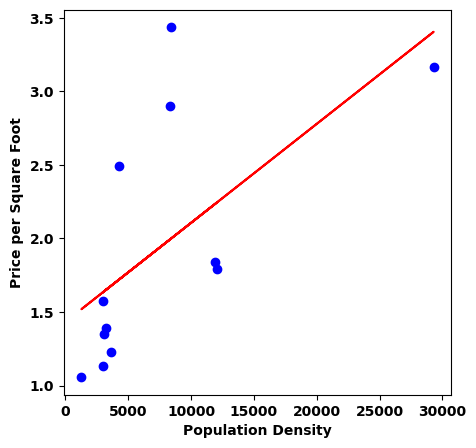

In [175]:
# Scatterplot - Price per Sqft vs Density
# x values
x_vals = data['Density']

# y values
y_vals = data['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'density' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Population Density")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between '% water' and 'price per sqft' is 0.76


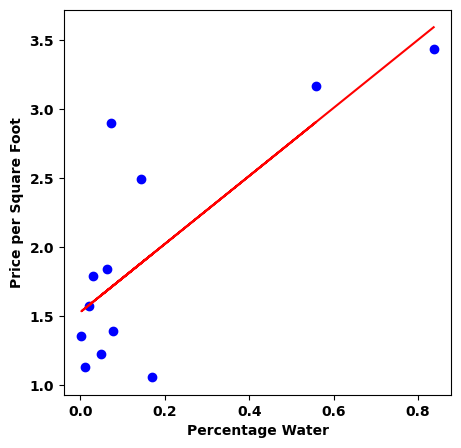

In [176]:
# Scatterplot - Price per Sqft vs % Water
# x values
x_vals = data['Percent_Water']

# y values
y_vals = data['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between '% water' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Percentage Water")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Listings per 1k Capita' and 'price per sqft' is -0.45


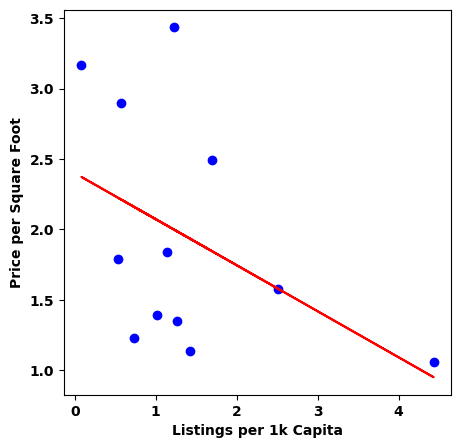

In [177]:
# Scatterplot - Price per Sqft vs Listings per 1k Capita
# x values
x_vals = data['Listings_per_1k_Capita']

# y values
y_vals = data['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Listings per 1k Capita' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Listings per 1k Capita")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Density' and 'Rent per Income' is 0.59


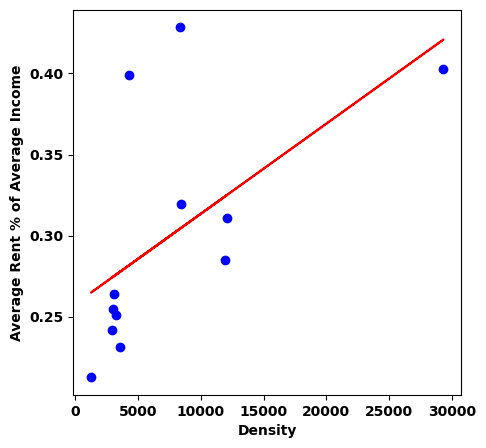

In [178]:
# Scatterplot - Rent per Income vs Density
# x values
x_vals = data['Density']

# y values
y_vals = data['Rent_per_Income']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Density' and 'Rent per Income' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Density")
plt.ylabel("Average Rent % of Average Income")
plt.plot(x_vals, regress_values, "r-")
plt.show()

In [179]:
## Write to csv
data.to_csv('Resources/final_data.csv')